In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pylab as plt
import mcmc_util
import numpy as np
from multiprocessing import Pool
import copy
import os


In [3]:
n_mcmc = (5*10**6)
thinning = 50
#n_mcmc = 10000

# Load theoretical results

In [4]:
# load asymptotic variance
asymp_var_array = np.load("./simulation_results/asympt_var.npy", allow_pickle=True)

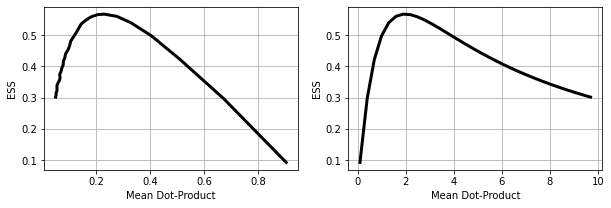

In [5]:
kappa_list_th = asymp_var_array[:,0]
dot_product_list_th = asymp_var_array[:,1]
velocity_list_th = asymp_var_array[:,2]


plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(dot_product_list_th, velocity_list_th, "k-", linewidth=3)
plt.ylabel("ESS")
plt.xlabel("Mean Dot-Product")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(kappa_list_th, velocity_list_th, "k-", linewidth=3)
plt.ylabel("ESS")
plt.xlabel("Mean Dot-Product")
plt.grid(True)


# helper function to load/save simulations

In [6]:
def save_result(filename, dbs_traj_list):
    """ dump results in a numpy file """
    delta_list = [traj["delta"] for traj in dbs_traj_list]
    kappa_list = [traj["kappa"] for traj in dbs_traj_list]
    ess_list = [traj["ess"] for traj in dbs_traj_list]
    mean_dot_list = [traj["mean_dot"] for traj in dbs_traj_list]
    step_list = [traj["steps"] for traj in dbs_traj_list]
    acceptance_list = [traj["acceptance_rate"] for traj in dbs_traj_list]
    DR_acceptance_list = [traj["DR_acceptance_rate"] for traj in dbs_traj_list]
    
    N_sim = len(step_list)
    results = np.zeros((N_sim,7))
    
    results[:,0] = np.array(delta_list)
    results[:,1] = kappa_list
    results[:,2] = ess_list
    results[:,3] = mean_dot_list
    results[:,4] = step_list
    results[:,5] = acceptance_list
    results[:,6] = DR_acceptance_list

    results.dump(filename)
    #print("results saved in {}".format(filename))
    
def load_result(filename):  
    """ load simulations from numpy file """
    results = np.load(filename, allow_pickle=True)
    result_dict = {"delta_list": results[:,0],
                    "kappa_list": results[:,1],
                    "ess_list": results[:,2],
                    "mean_dot_list": results[:,3],
                    "step_list": results[:,4],
                    "acceptance_list": results[:,5],
                    "DR_acceptance_list": results[:,6]}
    return result_dict

In [7]:
def run_dbps(param):
    """
    helper function to run the DBPS
    
    args:
    ====
     param: parameter necessary to run the DBPS
     
    out:
    ===
       {"delta": delta,
        "kappa": kappa,
        "ess": ess,
        "mean_dot": mean_dot,
        "steps": steps}
    """
    
    #run mcmc
    print("kappa:{0:2.3f} \t delta: {1:2.3f} \t nmcmc:{2:2.3f}".format(param["kappa"], param["delta"], param["n_mcmc"]))
    mcmc_traj = mcmc_util.DBPS(param)
    
    #gather statistics
    kappa = param["kappa"]
    delta = param["delta"]    
    ess = mcmc_util.normalized_ess(mcmc_traj["log_posterior"])["ESS_normalized"]
    steps = mcmc_traj["steps_between_bounces"]
    mean_dot = mcmc_traj["mean_dot_product"]
    acceptance_rate = mcmc_traj["acceptance_rate"]
    DR_acceptance_rate = mcmc_traj["DR_acceptance_rate"]

    
    
    return {"delta": delta,
            "kappa": kappa,
            "ess": ess,
            "mean_dot": mean_dot,
            "steps": steps,
            "acceptance_rate": acceptance_rate,
            "DR_acceptance_rate": DR_acceptance_rate}
    

# Gaussian Anisotropic Target Distributions

In [8]:
dim = 200
std_list = np.linspace(1,10,dim)

def log_target(x):
    return -0.5 * np.sum( (x/std_list)**2 )

def grad_target(x):
    return -x/(std_list**2)

In [9]:
# study the influence of the dimension
dim_list = [20,50,200]

kappa = 0.1
delta_list = [1.,2.]

for delta in delta_list:
    for dim in dim_list:
        print(f"Dimension{dim} \t delta:{delta}")
        std_list = np.linspace(1,10,dim)

        x_init = std_list*np.random.normal(0,1,dim)
        v_init = np.random.normal(0,1,dim)
        v_init = v_init / np.linalg.norm(v_init)

        param = {}
        param["x_init"] = x_init
        param["v_init"] = v_init
        param["n_mcmc"] = n_mcmc
        param["delta"] = delta
        param["kappa"] = kappa
        param["log_target"] = log_target
        param["grad_log_target"] = grad_target
        param["thinning"] = thinning
        param["verbose"] = True

        #create a list of parameters
        param_list = []
        kappa_list = 10**np.linspace(-2, 1, 25)
        for kappa in kappa_list:
            param_ = copy.deepcopy(param)
            param_["verbose"] = False
            param_["kappa"] = kappa
            param_list.append(param_)

        pool = Pool(processes=25)
        dbs_traj_list = pool.map(run_dbps, param_list)
        pool.close()
        pool.join()

        filename = f"aniso_d={dim}_delta={delta}.npy"
        filename = os.path.join("./simulation_results",filename)
        print(f"result saved in: {filename}")
        save_result(filename, dbs_traj_list)
    

Dimension20 	 delta:1.0
kappa:0.010 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.032 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.013 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.024 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.018 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.100 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.075 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.316 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.562 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.042 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.422 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.056 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.237 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.750 	 delta: 1.000 	 nmcmc:5000000.000
kappa:1.000 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.178 	 delta: 1.000 	 nmcmc:5000000.000
kappa:0.133 	 delta: 1.000 	 nmcmc:5000000.000
kappa:1.778 	 delta: 1.000 	 nmcmc:5000000.000
kappa:1.334 	 delta: 1.000 	 nmcmc:5000000.000
kappa:2.371 	 delta: 1.000 	 nmcmc:5000000.000
kappa:3.162 	 delta: 1.000 	 nmcmc:5

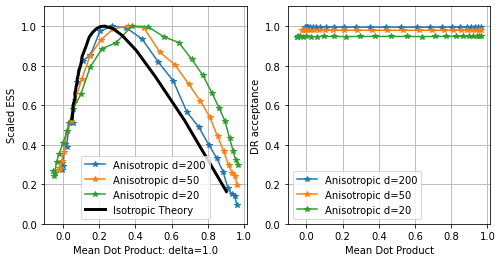

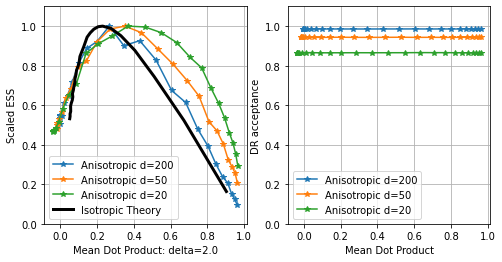

In [10]:
for delta in [1.0, 2.0]:
    dim=200
    #delta=1.0
    filename = f"aniso_d={dim}_delta={delta}.npy"
    filename = os.path.join("./simulation_results",filename)
    dbps_stats_200 = load_result(filename)

    dim=50
    #delta=1.0
    filename = f"aniso_d={dim}_delta={delta}.npy"
    filename = os.path.join("./simulation_results",filename)
    dbps_stats_50 = load_result(filename)

    dim=20
    #delta=1.0
    filename = f"aniso_d={dim}_delta={delta}.npy"
    filename = os.path.join("./simulation_results",filename)
    dbps_stats_20 = load_result(filename)

    fig = plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.plot(dbps_stats_200["mean_dot_list"], dbps_stats_200["ess_list"] / np.max(dbps_stats_200["ess_list"]), "-*", label="Anisotropic d=200" )
    #plt.plot(dbps_stats_100["mean_dot_list"], dbps_stats_100["ess_list"] / np.max(dbps_stats_100["ess_list"]), "-*", label="Anisotropic d=100" )
    plt.plot(dbps_stats_50["mean_dot_list"], dbps_stats_50["ess_list"] / np.max(dbps_stats_50["ess_list"]), "-*", label="Anisotropic d=50" )
    plt.plot(dbps_stats_20["mean_dot_list"], dbps_stats_20["ess_list"] / np.max(dbps_stats_20["ess_list"]), "-*", label="Anisotropic d=20" )
    plt.plot(dot_product_list_th, velocity_list_th / np.max(velocity_list_th), "k-", linewidth=3, label="Isotropic Theory" )
    plt.xlabel(f"Mean Dot Product: delta={delta}")
    plt.ylabel("Scaled ESS")
    plt.ylim(0,1.1)
    plt.grid(True)
    plt.legend()



    plt.subplot(1,2,2)
    plt.plot(dbps_stats_200["mean_dot_list"], dbps_stats_200["DR_acceptance_list"] , "-*", label="Anisotropic d=200" )
    plt.plot(dbps_stats_50["mean_dot_list"], dbps_stats_50["DR_acceptance_list"] , "-*", label="Anisotropic d=50" )
    plt.plot(dbps_stats_20["mean_dot_list"], dbps_stats_20["DR_acceptance_list"] , "-*", label="Anisotropic d=20" )
    plt.xlabel("Mean Dot Product")
    plt.ylabel("DR acceptance")

    plt.ylim(0,1.1)
    plt.grid(True)
    plt.legend()

    fig.savefig(f"./simulation_figures/dbps_anisotropic_delta={delta}.pdf") #, layout="tight")



# Study the sensitivity to kappa and delta on an isotropic Gaussian

In [11]:
dim = 100
std_list = np.ones(dim)

def log_target(x):
    return -0.5 * np.sum( (x/std_list)**2 )

def grad_target(x):
    return -x/(std_list**2)

In [12]:
delta_list = [0.04, 0.2, 1.0]
dim = 100
kappa = 0.1
delta = 1.
    
for delta in delta_list:
    print("delta= ", delta)

    x_init = std_list*np.random.normal(0,1,dim)
    v_init = np.random.normal(0,1,dim)
    v_init = v_init / np.linalg.norm(v_init)

    param = {}
    param["x_init"] = x_init
    param["v_init"] = v_init
    param["n_mcmc"] = n_mcmc
    param["delta"] = delta
    param["kappa"] = kappa
    param["log_target"] = log_target
    param["grad_log_target"] = grad_target
    param["thinning"] = thinning
    param["verbose"] = True
    
    #create a list of parameters
    param_list = []
    kappa_list = 10**np.linspace(-2, 1, 25)
    for kappa in kappa_list:
        param_ = copy.deepcopy(param)
        param_["verbose"] = False
        param_["kappa"] = kappa
        param_list.append(param_)

    pool = Pool(processes=25)
    dbs_traj_list = pool.map(run_dbps, param_list)
    pool.close()
    pool.join()

    filename = f"iso_d={dim}_delta={delta}.npy"
    filename = os.path.join("./simulation_results",filename)
    print(f"result saved in: {filename}")
    save_result(filename, dbs_traj_list)

delta=  0.04
kappa:0.024 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.075 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.056 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.042 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.013 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.032 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.018 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.010 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.316 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.422 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.133 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.100 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.562 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.178 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.237 	 delta: 0.040 	 nmcmc:5000000.000
kappa:0.750 	 delta: 0.040 	 nmcmc:5000000.000
kappa:1.000 	 delta: 0.040 	 nmcmc:5000000.000
kappa:2.371 	 delta: 0.040 	 nmcmc:5000000.000
kappa:1.778 	 delta: 0.040 	 nmcmc:5000000.000
kappa:1.334 	 delta: 0.040 	 nmcmc:5000000.000
kappa:5.623 	 delta: 0.040 	 nmcmc:5000000.000


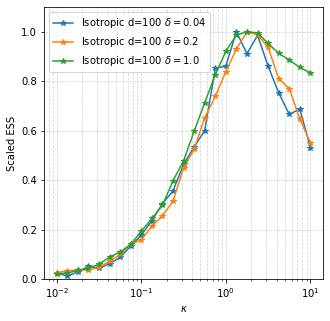

In [13]:
dim = 100
delta = 0.04
filename = f"iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_004 = load_result(filename)

delta = 0.2
filename = f"iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_02 = load_result(filename)

delta = 1.
filename = f"iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_1 = load_result(filename)


fig = plt.figure(figsize=(5,5))
plt.plot(dbps_stats_004["kappa_list"], dbps_stats_004["ess_list"] / np.max(dbps_stats_004["ess_list"]), "-*", label=r"Isotropic d=100 $\delta=0.04$" )
plt.plot(dbps_stats_02["kappa_list"], dbps_stats_02["ess_list"] / np.max(dbps_stats_02["ess_list"]), "-*", label=r"Isotropic d=100 $\delta=0.2$" )
plt.plot(dbps_stats_1["kappa_list"], dbps_stats_1["ess_list"] / np.max(dbps_stats_1["ess_list"]), "-*", label=r"Isotropic d=100 $\delta=1.0$" )


#plt.plot(kappa_list_th, velocity_list_th / np.max(velocity_list_th), "k-", linewidth=3, label="Isotropic Theory" )

plt.xlabel(r"$\kappa$")
plt.ylabel("Scaled ESS")

plt.xscale("log")
plt.ylim(0,1.1)
#plt.grid(True)
plt.grid(True,which="both", linestyle="--", alpha=0.5)
plt.legend()


fig.savefig("./simulation_figures/dbps_isotropic_delta_study.pdf")


# Logistic target Distribution

In [14]:
def log_target(x):
    return np.sum( -x - 2*np.log(1.+np.exp(-x)) )

def grad_target(x):
    dim = x.shape[0]
    return -np.ones(dim) + 2. / (1.+np.exp(x))

def generate(dim):
    """ generate a sample from the logistic distribution """
    x = np.random.rand(dim)
    return np.log(x / (1. - x) )

In [15]:
dim = 100

x_init = generate(dim)
v_init = np.random.normal(0,1,dim)
v_init = v_init / np.linalg.norm(v_init)
kappa = 0.1
delta = 0.7

param = {}
param["x_init"] = x_init
param["v_init"] = v_init
param["n_mcmc"] = n_mcmc
param["delta"] = delta
param["kappa"] = kappa
param["log_target"] = log_target
param["grad_log_target"] = grad_target
param["thinning"] = thinning
param["verbose"] = True

#create a list of parameters
param_list = []
kappa_list = 10**np.linspace(-2, 1, 25)
for kappa in kappa_list:
    param_ = copy.deepcopy(param)
    param_["verbose"] = False
    param_["kappa"] = kappa
    param_list.append(param_)
    
pool = Pool(processes=25)
dbs_traj_list = pool.map(run_dbps, param_list)
pool.close()
pool.join()


filename = f"logistic_iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
save_result(filename, dbs_traj_list)
print(f"result saved in: {filename}")

kappa:0.010 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.013 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.018 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.024 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.042 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.750 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.237 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.056 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.075 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.562 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.032 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.316 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.133 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.178 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.422 	 delta: 0.700 	 nmcmc:5000000.000
kappa:0.100 	 delta: 0.700 	 nmcmc:5000000.000
kappa:1.000 	 delta: 0.700 	 nmcmc:5000000.000
kappa:1.778 	 delta: 0.700 	 nmcmc:5000000.000
kappa:1.334 	 delta: 0.700 	 nmcmc:5000000.000
kappa:3.162 	 delta: 0.700 	 nmcmc:5000000.000
kappa:10.000 	 delta: 0.700 	 nmcmc:5000000.000
kappa:4.217 

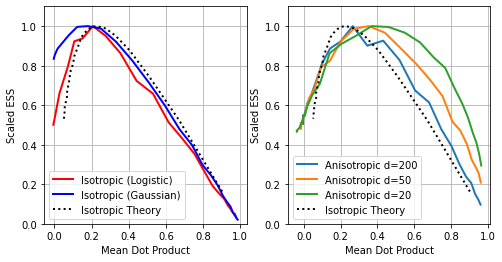

In [16]:
fig = plt.figure(figsize=(8,4))


plt.subplot(1,2,1)

dim=100
delta=0.7
filename = f"logistic_iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
logistic_dbps_stats_100 = load_result(filename)

dim=100
delta=1.0
filename = f"iso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_100 = load_result(filename)


plt.plot(logistic_dbps_stats_100["mean_dot_list"], logistic_dbps_stats_100["ess_list"] / np.max(logistic_dbps_stats_100["ess_list"]), "r-", label="Isotropic (Logistic)", linewidth=2 )
plt.plot(dbps_stats_100["mean_dot_list"], dbps_stats_100["ess_list"] / np.max(dbps_stats_100["ess_list"]), "b-", label="Isotropic (Gaussian)", linewidth=2 )
plt.plot(dot_product_list_th, velocity_list_th / np.max(velocity_list_th), "k:", linewidth=2, label="Isotropic Theory" )
plt.xlabel("Mean Dot Product")
plt.ylabel("Scaled ESS")
plt.ylim(0,1.1)
plt.grid(True)
plt.legend()


plt.subplot(1,2,2)
dim=200
delta=2.0
filename = f"aniso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_200 = load_result(filename)

dim=50
delta=2.0
filename = f"aniso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_50 = load_result(filename)


dim=20
delta=2.0
filename = f"aniso_d={dim}_delta={delta}.npy"
filename = os.path.join("./simulation_results",filename)
dbps_stats_20 = load_result(filename)

plt.plot(dbps_stats_200["mean_dot_list"], dbps_stats_200["ess_list"] / np.max(dbps_stats_200["ess_list"]), "-", label="Anisotropic d=200", linewidth=2 )
plt.plot(dbps_stats_50["mean_dot_list"], dbps_stats_50["ess_list"] / np.max(dbps_stats_50["ess_list"]), "-", label="Anisotropic d=50", linewidth=2 )
plt.plot(dbps_stats_20["mean_dot_list"], dbps_stats_20["ess_list"] / np.max(dbps_stats_20["ess_list"]), "-", label="Anisotropic d=20", linewidth=2 )
plt.plot(dot_product_list_th, velocity_list_th / np.max(velocity_list_th), "k:", linewidth=2, label="Isotropic Theory" )
plt.xlabel("Mean Dot Product")
plt.ylabel("Scaled ESS")
plt.ylim(0,1.1)
plt.grid(True)
plt.legend()

fig.savefig("./simulation_figures/dbps_iso_aniso_study.pdf")